In [116]:
%config InlineBackend.figure_formats = ['svg','png']

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.optim import SGD, Adam
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tqdm
import random

from pathlib import Path


In [118]:
def set_all_seed(seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

## Create a toy dataset

In [119]:
X, y = make_classification(1000, 20, n_informative=10, random_state=0)

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

## Define a NN architecture

In [120]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        # self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        # x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [121]:
def train(model, optimizer_class, lr, negative_loss = False, create_plot = True, EPOCHS = 200, uniform_label = False):
    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))
    loss_fn   = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr)

    for epoch in range(EPOCHS):
        y_pred = model(X_train)

        if uniform_label:
            # uniform labels
            batch_size, num_g_class = y_pred.shape
            # init uniform protected attributes
            _y_train = (1/num_g_class) * torch.ones_like(y_pred)

            loss = loss_fn(y_pred, _y_train) * (-1 if negative_loss else 1)
        else:
            loss = loss_fn(y_pred, y_train) * (-1 if negative_loss else 1)

        loss_list[epoch] = loss.item() * (-1 if negative_loss else 1)
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            loss_list[epoch] = loss_fn(y_pred, y_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()

    # print("Pred Accuracy", accuracy_score(np.argmax(y_pred,axis=1), y_test))
    # print("Inverse Pred Accuracy", accuracy_score(1-np.argmax(y_pred,axis=1), y_test))

    if create_plot:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 6), sharex=True)

        ax1.plot(accuracy_list)
        ax1.set_ylabel("validation accuracy")
        ax2.plot(loss_list)
        ax2.set_ylabel("validation loss")
        ax2.set_xlabel("epochs")
    
    return accuracy_list, loss_list

In [122]:
def exam_unlearning(
    optimizers = [(Adam, 0.001)],
    negative_loss = [False],
    epochs  = [200],
    uniform_label = [False],
    seed = None,
    plot_path = Path("plots"),
    file_name = None,
    display_info = True
    ):
    
    if seed is not None:
        set_all_seed(seed)

    # Init model
    model = Model(X_train.shape[1])

    accs = []
    losses = []

    for _opt, _neg_loss, _n_epoch, _uniform_label in zip(optimizers, negative_loss, epochs, uniform_label):
        _accs, _losses = train(model, _opt[0], _opt[1], negative_loss = _neg_loss, EPOCHS=_n_epoch, create_plot=False, uniform_label = _uniform_label)
        accs.append(_accs)
        losses.append(_losses)
    
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(min(4*sum(epochs)/200, 16), 3), sharex=True)

    # axs_top = max(np.concatenate(losses))
    # axs_scaler = (axs_top-min(np.concatenate(losses)))*0.1

    epoch_count = 1
    for _idx, _epoch in enumerate(epochs):
        epoch_count+=_epoch

        _x = [i for i in range(epoch_count-_epoch, epoch_count)]
        ax1.plot(_x, accs[_idx],  color='g' if negative_loss[_idx] else "r", linestyle = ':' if uniform_label[_idx] else "-",)
        ax2.plot(_x, losses[_idx], color='g' if negative_loss[_idx] else "r", linestyle = ':' if uniform_label[_idx] else "-",)
        
        if display_info:
            ax1.axvline(epoch_count, ls="--", color="k")
            ax2.axvline(epoch_count, ls="--", color="k")

            ax2.text(epoch_count-_epoch/2, 1.23, 
            'Opt: {}, LR: {}, -1*Loss: {}'.format(
                optimizers[_idx][0].__name__,
                optimizers[_idx][1],
                negative_loss[_idx],
                ),
            c="k",
            horizontalalignment='center',
            verticalalignment='bottom')
    
    ax1.set_ylim([0.1, 0.9])
    ax2.set_ylim([0.4, 1.2])

    ax1.axhline(y=0.5, color='y', linestyle=(0, (5, 10)))
    ax2.axhline(y=0.75, color='y', linestyle=(0, (5, 10)))

    ax2.set_xlabel("epochs")
    ax1.set_ylabel("Dev Acc")
    ax2.set_ylabel("Dev Loss")

    if file_name is not None:
        fig.savefig(plot_path / file_name, dpi=960, bbox_inches="tight") 

52980


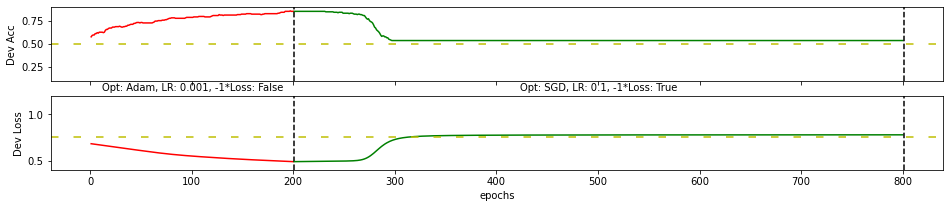

In [150]:
set_all_seed(2021)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 0.1)],
        negative_loss = [False, True],
        epochs  = [200, 600],
        uniform_label= [False, False],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp4_SGD_1e-1"
        )

52980


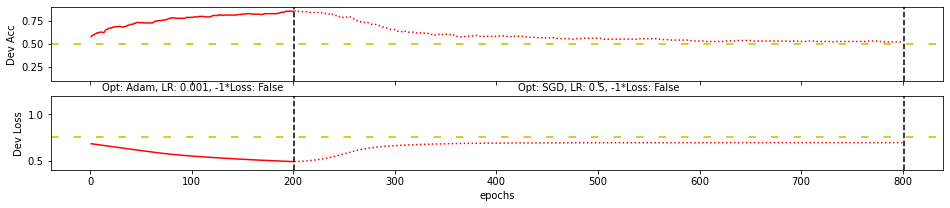

In [155]:
set_all_seed(2021)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 0.5)],
        negative_loss = [False, False],
        epochs  = [200, 600],
        uniform_label= [False, True],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp5_SGD_5e-1"
        )

# Learn

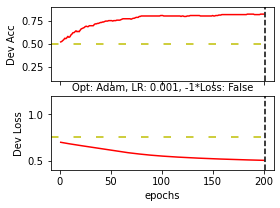

In [124]:
exam_unlearning(
    optimizers = [(Adam, 0.001)],
    negative_loss = [False],
    epochs  = [200],
    uniform_label= [False],
    plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
    file_name = "exp1_minimize_CE"
    )

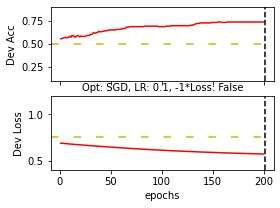

In [125]:
exam_unlearning(
    optimizers = [(SGD, 0.1)],
    negative_loss = [False],
    epochs  = [200],
    uniform_label= [False],

    )

# Unlearn -- Reverse Loss

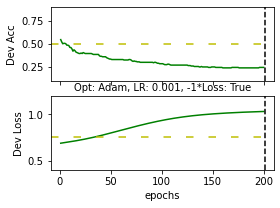

In [126]:
exam_unlearning(
    optimizers = [(Adam, 0.001)],
    negative_loss = [True],
    epochs  = [200],
    uniform_label= [False],
    plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
    file_name = "exp1_minimize_negative_CE"
    )

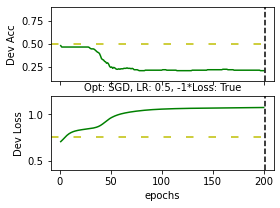

In [127]:
exam_unlearning(
    optimizers = [(SGD, 0.5)],
    negative_loss = [True],
    epochs  = [200],
    uniform_label= [False],
    )

## learning to forget

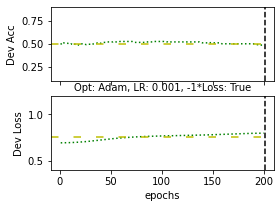

In [128]:
exam_unlearning(
    optimizers = [(Adam, 0.001)],
    negative_loss = [True],
    epochs  = [200],
    uniform_label= [True],
    plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
    file_name = "exp2_minimize_NCE_uniform_labels"
    )

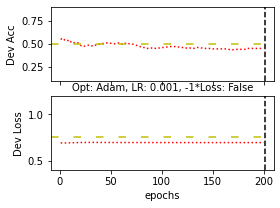

In [129]:
exam_unlearning(
    optimizers = [(Adam, 0.001)],
    negative_loss = [False],
    epochs  = [200],
    uniform_label= [True],    
    plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
    file_name = "exp2_minimize_CE_uniform_labels"
    )

## Exp 1: Unlearn a trained model. Same Optimizer, (Adam, 0.001)

17611


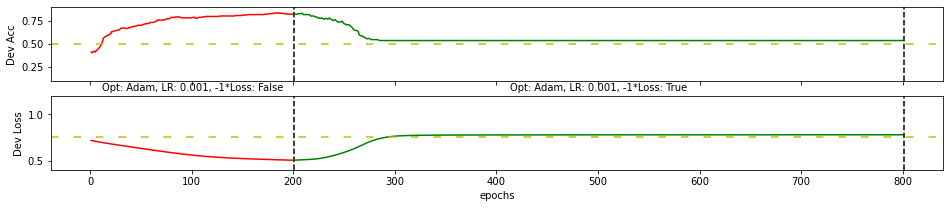

In [130]:
set_all_seed(1)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.001)],
        negative_loss = [False, True],
        epochs  = [200, 600],
        uniform_label= [False, False],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp3_Adam_1e-3_1"
        )

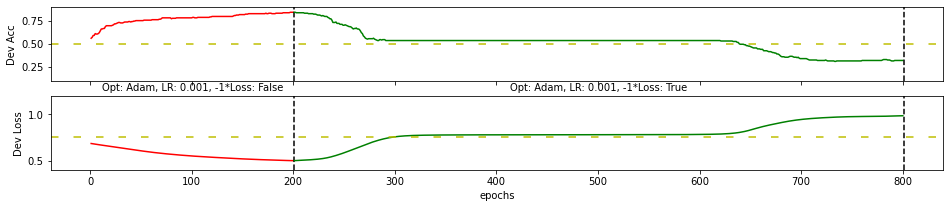

In [131]:
for _seed in [848484]:#, 896312]:
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.001)],
        negative_loss = [False, True],
        epochs  = [200, 600],
        uniform_label= [False, False],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp3_Adam_1e-3_2"
        )

69681


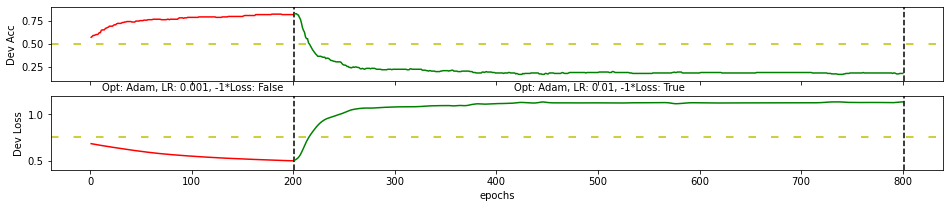

In [132]:
set_all_seed(2022)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.01)],
        negative_loss = [False, True],
        epochs  = [200, 600],
        uniform_label= [False, False],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp4_Adam_1e-2"
        )

52980


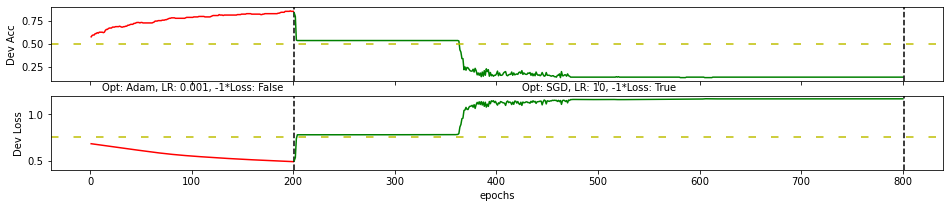

In [133]:
set_all_seed(2021)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 10)],
        negative_loss = [False, True],
        epochs  = [200, 600],
        uniform_label= [False, False],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp4_SGD_1e+1"
        )

# Simulating Batch Update

81221


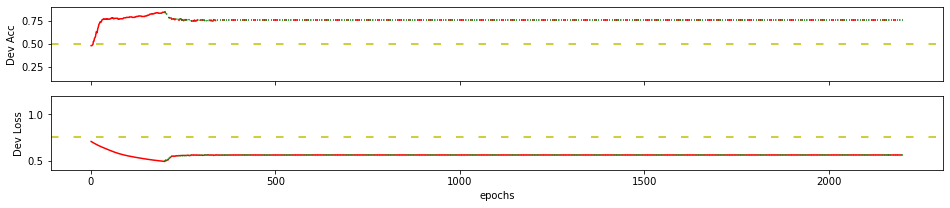

In [134]:
set_all_seed(2020)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    _each_epoch = [2 , 4]
    n_repeats = int(2000/sum(_each_epoch))
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.01)] +  [(Adam, 0.001), (Adam, 0.01)]*n_repeats,
        negative_loss = [False, True] + [False, True]*n_repeats,
        epochs  = [200, 2] + _each_epoch * n_repeats,
        uniform_label= [False, False] + [False, True]*n_repeats,
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp5_Adam_1e-3_1e-2",
        display_info = False
        )

81221


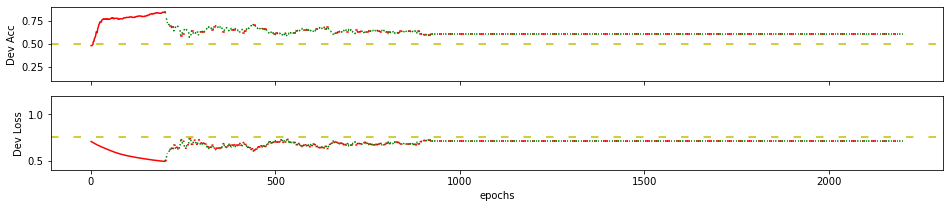

In [135]:
set_all_seed(2020)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    _each_epoch = [2 , 4]
    n_repeats = int(2000/sum(_each_epoch))
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.01)] +  [(Adam, 0.001), (Adam, 0.1)]*n_repeats,
        negative_loss = [False, True] + [False, True]*n_repeats,
        epochs  = [200, 2] + _each_epoch * n_repeats,
        uniform_label= [False, False] + [False, True]*n_repeats,
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp5_Adam_1e-3_1e-1",
        display_info = False
        )

81221


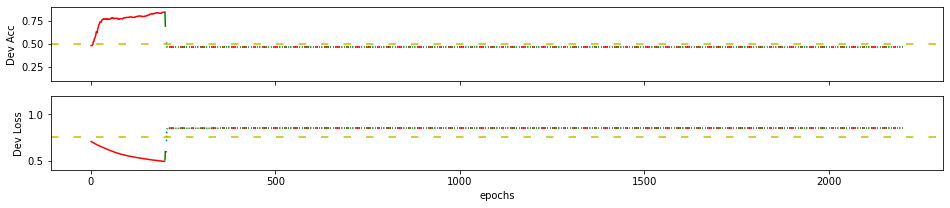

In [136]:
set_all_seed(2020)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    _each_epoch = [2 , 4]
    n_repeats = int(2000/sum(_each_epoch))
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 10)] +  [(SGD, 0.001), (SGD, 10)]*n_repeats,
        negative_loss = [False, True] + [False, True]*n_repeats,
        epochs  = [200, 2] + _each_epoch * n_repeats,
        uniform_label= [False, False] + [False, True]*n_repeats,
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp5_SGD_1e-3_1e+1",
        display_info = False
        )

## Exp 2 Relearn a model

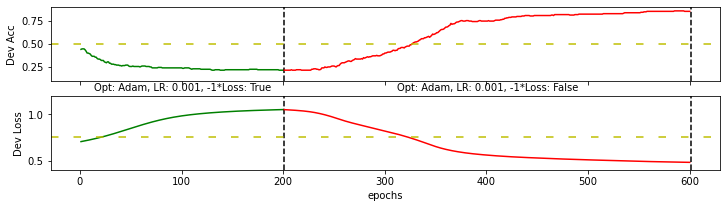

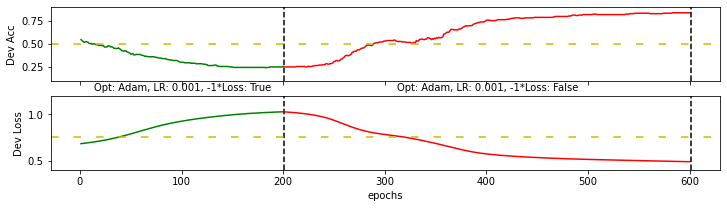

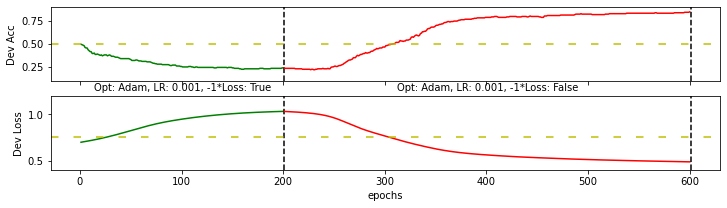

In [137]:
set_all_seed(0)
for _ in range(3):
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.001)],
        negative_loss = [True, False],
        epochs  = [200, 400],
        uniform_label= [False, False],
        seed=random.randint(0,1e+5)
        )

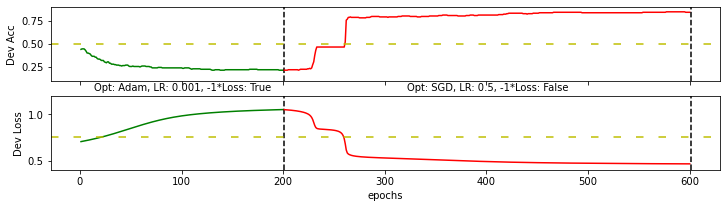

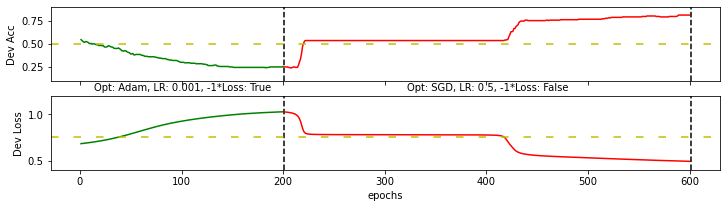

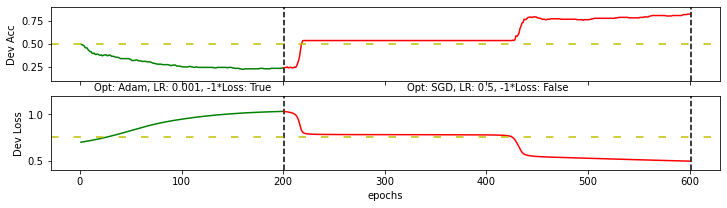

In [138]:
set_all_seed(0)
for _ in range(3):
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 0.5)],
        negative_loss = [True, False],
        epochs  = [200, 400],
        uniform_label= [False, False],
        seed=random.randint(0,1e+5)
        )

## Unlearning through learning uniform preds

69882


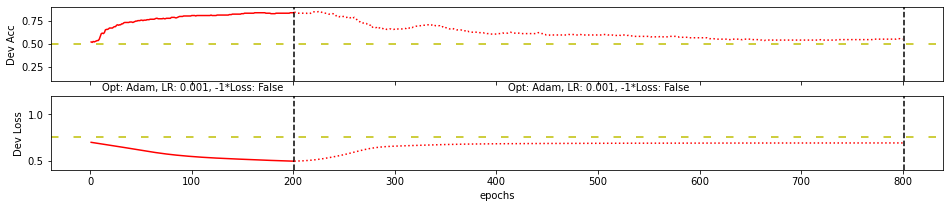

In [139]:
set_all_seed(2018)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.001)],
        negative_loss = [False, False],
        epochs  = [200, 600],
        uniform_label= [False, True],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp5_Adam_1e-3",
        )

26104


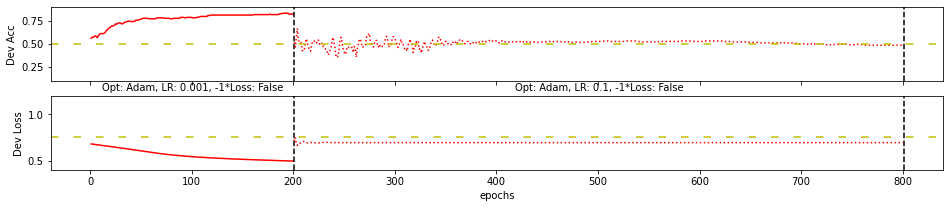

In [140]:
set_all_seed(2017)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.1)],
        negative_loss = [False, False],
        epochs  = [200, 600],
        uniform_label= [False, True],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp5_Adam_1e-1",
        )

96721


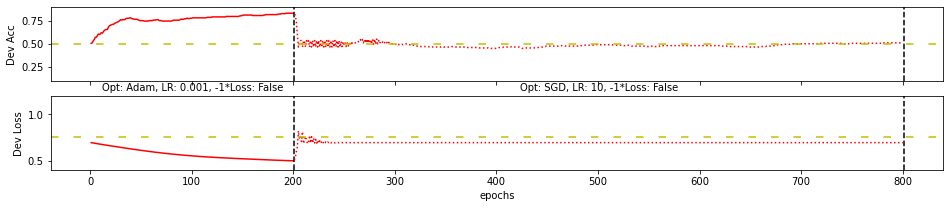

In [141]:
set_all_seed(2016)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 10)],
        negative_loss = [False, False],
        epochs  = [200, 600],
        uniform_label= [False, True],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp5_SGD_1e+1",
        )

95263


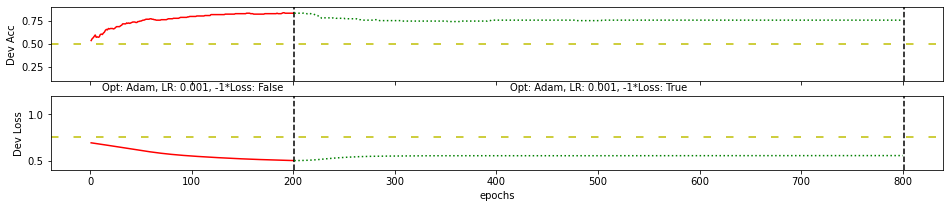

In [142]:
set_all_seed(2015)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.001)],
        negative_loss = [False, True],
        epochs  = [200, 600],
        uniform_label= [False, True],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp6_Adam_1e-3",
        )

41333


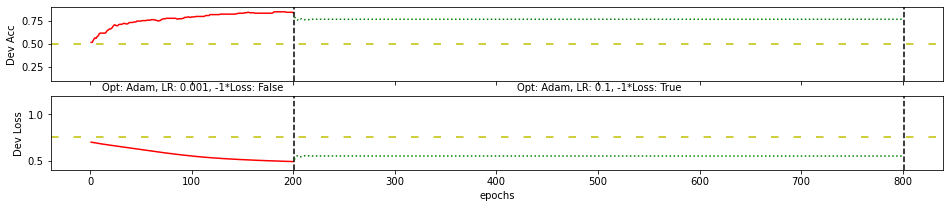

In [143]:
set_all_seed(2014)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.1)],
        negative_loss = [False, True],
        epochs  = [200, 600],
        uniform_label= [False, True],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp6_Adam_1e-1",
        )

55728


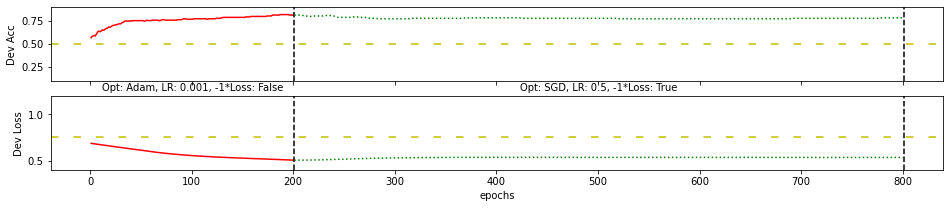

In [144]:
set_all_seed(2013)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 0.5)],
        negative_loss = [False, True],
        epochs  = [200, 600],
        uniform_label= [False, True],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp6_SGD_5e-1",
        )

96721


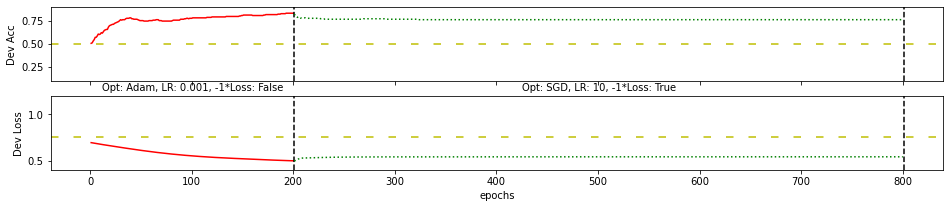

In [145]:
set_all_seed(2016)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 10)],
        negative_loss = [False, True],
        epochs  = [200, 600],
        uniform_label= [False, True],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp6_SGD_1e+1",
        )

# Appendix

17611


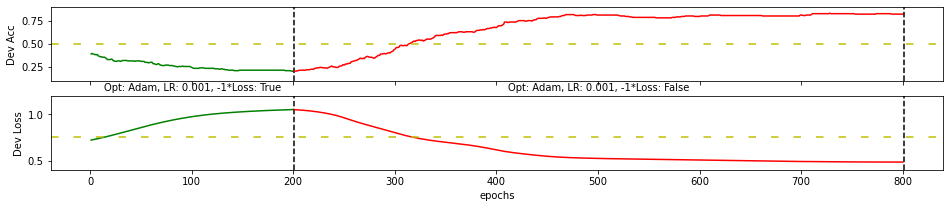

In [146]:
set_all_seed(1)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (Adam, 0.001)],
        negative_loss = [True, False],
        epochs  = [200, 600],
        uniform_label= [False, False],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        # file_name = "exp3_Adam_1e-3_1"
        )

17611


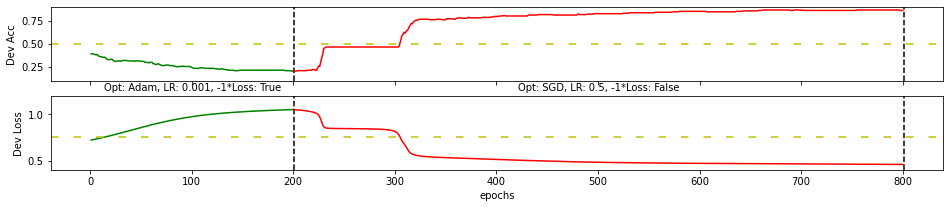

In [147]:
set_all_seed(1)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 0.5)],
        negative_loss = [True, False],
        epochs  = [200, 600],
        uniform_label= [False, False],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp7_SGD_5e-1"
        )

17611


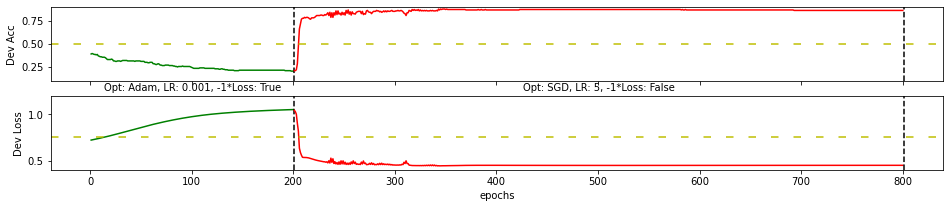

In [148]:
set_all_seed(1)
for _ in range(1):
    _seed = random.randint(0,1e+5)
    print(_seed)
    exam_unlearning(
        optimizers = [(Adam, 0.001), (SGD, 5)],
        negative_loss = [True, False],
        epochs  = [200, 600],
        uniform_label= [False, False],
        seed=_seed,
        plot_path = Path(r"D:\Project\XH-PhD\Meeting Recap\Img\Adv_Learn_to_Forget"),
        file_name = "exp7_SGD_5e-0"
        )